In [18]:
import numpy as np
import time
import matplotlib.pyplot as plt
import seaborn as sns

iris = np.genfromtxt('iris.txt')

######## DO NOT MODIFY THIS FUNCTION ########
def draw_rand_label(x, label_list):
    seed = abs(np.sum(x))
    while seed < 1:
        seed = 10 * seed
    seed = int(1000000 * seed)
    np.random.seed(seed)
    return np.random.choice(label_list)
#############################################

# Function seen in lab 2
def minkowski_mat(X, y, p=2):
    return (np.sum((np.abs(y - X)) ** p, axis=1)) ** (1.0 / p)

class Q1:

    def feature_means(self, iris):
        return np.mean(iris[:, 0:4], axis=0)

    def empirical_covariance(self, iris):
        return np.cov(iris[:, 0:4], rowvar=False)

    def feature_means_class_1(self, iris):
        filtered_iris_c1 = iris[iris[:, 4] == 1]
        return np.mean(filtered_iris_c1[:, 0:4], axis=0)

    def empirical_covariance_class_1(self, iris):
        filtered_iris_c1 = iris[iris[:, 4] == 1]
        return np.cov(filtered_iris_c1[:, 0:4], rowvar=False)

class HardParzen:

    def __init__(self, h):
        self.h = h
        self.X_train = None
        self.y_train = None
        self.label_list = None

    def fit(self, train_inputs, train_labels):
        self.X_train = train_inputs
        self.y_train = train_labels
        self.label_list = np.unique(self.y_train)

    def predict(self, test_data):
        if self.X_train is None or self.y_train is None:
            pass
        else:
            predictions = []
            for x in test_data:
                # Compute L1 distances to all training samples
                distances = np.sum(np.abs(self.X_train - x), axis=1)
                # Find neighbors within radius h
                neighbor_indices = np.where(distances < self.h)[0]
                if len(neighbor_indices) == 0:
                    # No neighbors found, assign random label
                    random_label = draw_rand_label(x, self.label_list)
                    predictions.append(random_label)
                else:
                    # Get labels of neighbors
                    neighbor_labels = self.y_train[neighbor_indices]
                    # Count occurrences of each label
                    unique_labels, counts = np.unique(neighbor_labels, return_counts=True)
                    # Handle ties by selecting the smallest label
                    max_count = np.max(counts)
                    candidates = unique_labels[counts == max_count]
                    predicted_label = np.min(candidates)
                    predictions.append(predicted_label)
            return np.array(predictions)

    def score(self, X_val, y_val):
        y_pred = self.predict(X_val)
        return np.mean(y_pred == y_val)

def soft_parzen_weights_l1(distances, sigma, dimension):
    normalization_constant = (1 / ((2 * np.pi) ** (dimension / 2) * sigma ** dimension))
    exponent = -0.5 * (distances ** 2) / sigma ** 2
    w = normalization_constant * np.exp(exponent)
    w = np.clip(w, a_min=1e-8, a_max=None)
    return w

class SoftRBFParzen:

    def __init__(self, sigma):
        self.sigma = sigma
        self.X_train = None
        self.y_train = None
        self.label_list = None

    def fit(self, train_inputs, train_labels):
        self.X_train = train_inputs
        self.y_train = train_labels
        self.label_list = np.unique(train_labels)

    def predict(self, test_data):
        if self.X_train is None or self.y_train is None:
            pass
        else:
            predictions = []
            dimension = self.X_train.shape[1]
            for x in test_data:
                # Compute L1 distances to all training samples
                distances = np.sum(np.abs(self.X_train - x), axis=1)
                # Compute weights
                weights = soft_parzen_weights_l1(distances, self.sigma, dimension)
                # For each label, sum weights
                total_weights = np.zeros(len(self.label_list))
                for idx, label in enumerate(self.label_list):
                    indices = np.where(self.y_train == label)[0]
                    total_weights[idx] = np.sum(weights[indices])
                # Predict label with highest total weight
                predicted_label = self.label_list[np.argmax(total_weights)]
                predictions.append(predicted_label)
            return np.array(predictions)

    def score(self, X_val, y_val):
        y_pred = self.predict(X_val)
        return np.mean(y_pred == y_val)

def split_dataset(iris):

    row_index_list = np.arange(iris.shape[0])

    # Filtering here

    X_train = iris[(row_index_list % 5 == 0) | (row_index_list % 5 == 1) | (row_index_list % 5 == 2)]
    X_valid = iris[row_index_list % 5 == 3]
    X_test = iris[row_index_list % 5 == 4]

    return X_train, X_valid, X_test

class ErrorRate:
    def __init__(self, x_train, y_train, x_val, y_val):
        self.x_train = x_train
        self.y_train = y_train
        self.x_val = x_val
        self.y_val = y_val

    def hard_parzen(self, h):
        hard_parzen = HardParzen(h)
        hard_parzen.fit(self.x_train, self.y_train)
        return 1 - hard_parzen.score(self.x_val, self.y_val)

    def soft_parzen(self, sigma):
        soft_parzen = SoftRBFParzen(sigma)
        soft_parzen.fit(self.x_train, self.y_train)
        return 1 - soft_parzen.score(self.x_val, self.y_val)

    def get_val_errors(self):
        listOfValues = np.array([0.01, 0.1, 0.2, 0.3, 0.4, 0.5, 1.0, 3.0, 10.0, 20.0])

        errorSoft_vectorized = np.vectorize(self.soft_parzen)
        errorSoft = errorSoft_vectorized(listOfValues)

        errorHard_vectorized = np.vectorize(self.hard_parzen)
        errorHard = errorHard_vectorized(listOfValues)

        return np.array([errorHard, errorSoft])

    def get_times(self, listOfValues):
        errors_hard = []
        errors_soft = []

        for param in listOfValues:
            start_time = time.time()
            self.hard_parzen(param)
            end_time = time.time()

            errors_hard.append((end_time - start_time)*1000)

            start_time = time.time()
            self.soft_parzen(param)
            end_time = time.time()

            errors_soft.append((end_time - start_time)*1000)

        return errors_hard, errors_soft

def get_test_errors(iris):
    dataset = split_dataset(iris)

    listOfValues = np.array([0.01, 0.1, 0.2, 0.3, 0.4, 0.5, 1.0, 3.0, 10.0, 20.0])

    X_train = dataset[0][:, 0:4]
    y_train = dataset[0][:, 4]

    X_valid = dataset[1][:, 0:4]
    y_valid = dataset[1][:, 4]

    X_test = dataset[2][:, 0:4]
    y_test = dataset[2][:, 4]

    select_params = ErrorRate(X_train, y_train, X_valid, y_valid).get_val_errors()

    hStar = listOfValues[np.argmin(select_params[0, :])]
    sigmaStar = listOfValues[np.argmin(select_params[1, :])]

    X = np.vstack([X_train, X_valid])
    y = np.hstack([y_train, y_valid])

    errorRates = ErrorRate(X, y, X_test, y_test)
    
    return np.array([errorRates.hard_parzen(hStar), errorRates.soft_parzen(sigmaStar)])

def random_projections(X, A):
    
    projection = (1/(np.sqrt(2)))*X@A
    return projection

# Test of functions

#q1 = Q1()
# print(q1.feature_means(iris))
# print(q1.empirical_covariance(iris))
# print(q1.feature_means_class_1(iris))
# print(q1.empirical_covariance_class_1(iris))

# X_trainTEST = np.array([[1, 1], [2, 2], [3, 3], [6, 6], [7, 7], [8, 8]])
# affaire = split_dataset(X_trainTEST)
# print(affaire)

# TEST FOR PROJECTION:

#X = np.array([[1, 2, 3, 4],
#              [5, 6, 7, 8],
#              [9, 10, 11, 12]])  

#A = np.array([[1, 0],
#              [0, 1],
#              [1, 0],
#              [0, 1]])  

#projection = random_projections(X, A)

#print(projection)

Test Points: 
[[ 2.5  2.5]
 [ 5.5  5.5]
 [ 7.5  7.5]
 [10.  10. ]
 [12.  12. ]
 [-0.5  3. ]]
Predictions: 
[0 1 0 1 1 0]


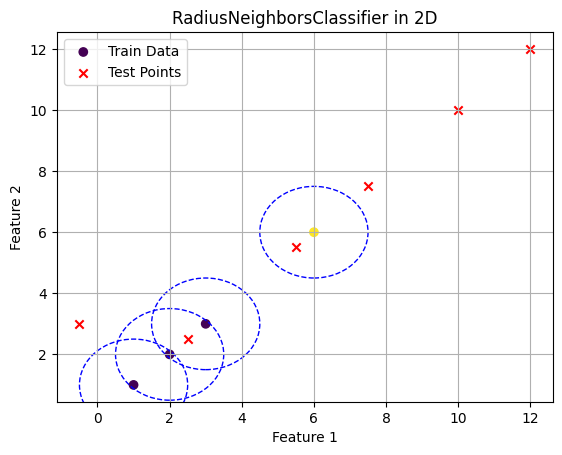

errorRate Hard = 0.0


In [7]:
# Generate a simple 2D dataset with two classes
X_train = np.array([[1, 1], [2, 2], [3, 3], [6, 6]])
X_valid = np.array([[7, 7], [8, 8]])
y_train = np.array([0, 0, 0, 1])
y_valid = np.array([1,1])
X_test = np.array([[2.5, 2.5], [5.5, 5.5], [7.5, 7.5], [10,10], [12,12], [-0.5,3]])

radius_knn = HardParzen(h = 1.5)
radius_knn.fit(X_train, y_train)
predictions = radius_knn.predict(X_test)


print(f"Test Points: \n{X_test}")
print(f"Predictions: \n{predictions}")

# Plot the training data and decision areas
plt.scatter(X_train[:, 0], X_train[:, 1], c=y_train, marker='o', label='Train Data')

# Plot test points with different markers
plt.scatter(X_test[:, 0], X_test[:, 1], marker='x', color='red', label='Test Points')

# Plot the radius boundaries around the train points
for point in X_train:
    circle = plt.Circle(point, radius=1.5, color='blue', fill=False, linestyle='--')
    plt.gca().add_artist(circle)

plt.legend()
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.title("RadiusNeighborsClassifier in 2D")
plt.grid(True)
plt.show()

error_rate = ErrorRate(X_train, y_train, X_valid, y_valid)
print("errorRate Hard = " + str(error_rate.hard_parzen(1.5)))


Predicted Classes:
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1.
 1. 1. 1. 1. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
True label:
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]


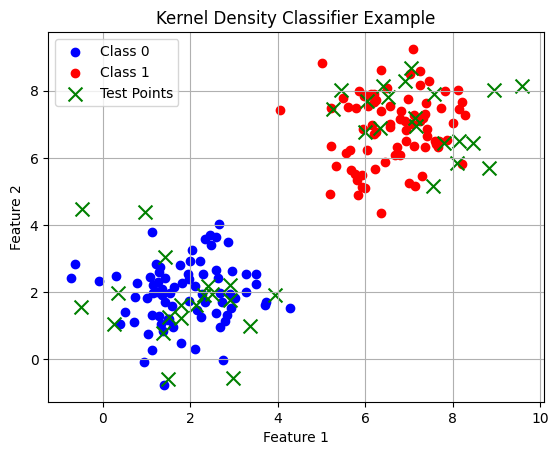

Error Rate (Soft Parzen) = 0.025000000000000022


In [8]:
# Generate training and validation data
X_class_0 = np.random.randn(80, 2) + [2, 2] # Class 0 centered at (2, 2)
X_valid_0 = np.random.randn(20,2) + [2,2]
X_class_1 = np.random.randn(80, 2) + [7, 7]  # Class 1 centered at (7, 7)
X_valid_1 = np.random.randn(20,2) + [7,7]

y_class_0 = np.zeros(80)
y_class_1 = np.ones(80)

y_valid_0 = np.zeros(20)
y_valid_1 = np.ones(20)

# Combine the two classes
X_train = np.vstack([X_class_0, X_class_1])
y_train = np.hstack([y_class_0, y_class_1])

X_valid = np.vstack([X_valid_0, X_valid_1])
y_valid = np.hstack([y_valid_0, y_valid_1])

# Step 2: Fit the SoftRBFParzen model on the training data
kde = SoftRBFParzen(sigma=0.2)
kde.fit(X_train, y_train)

# Predict the class with the highest probability
predictions = kde.predict(X_valid)

# Output
print("Predicted Classes:\n", predictions)
print("True label:\n", y_valid)

# Plot the data and the test points
plt.scatter(X_class_0[:, 0], X_class_0[:, 1], color='blue', label='Class 0')
plt.scatter(X_class_1[:, 0], X_class_1[:, 1], color='red', label='Class 1')
plt.scatter(X_valid[:, 0], X_valid[:, 1], color='green', marker='x', s=100, label='Test Points')
plt.legend()
plt.title('Kernel Density Classifier Example')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.grid(True)
plt.show()

# Calculate and print the error rate
errorRate = ErrorRate(X_train, y_train, X_valid, y_valid)
print("Error Rate (Soft Parzen) = " + str(errorRate.soft_parzen(0.2))) # sigma opt = 0.2

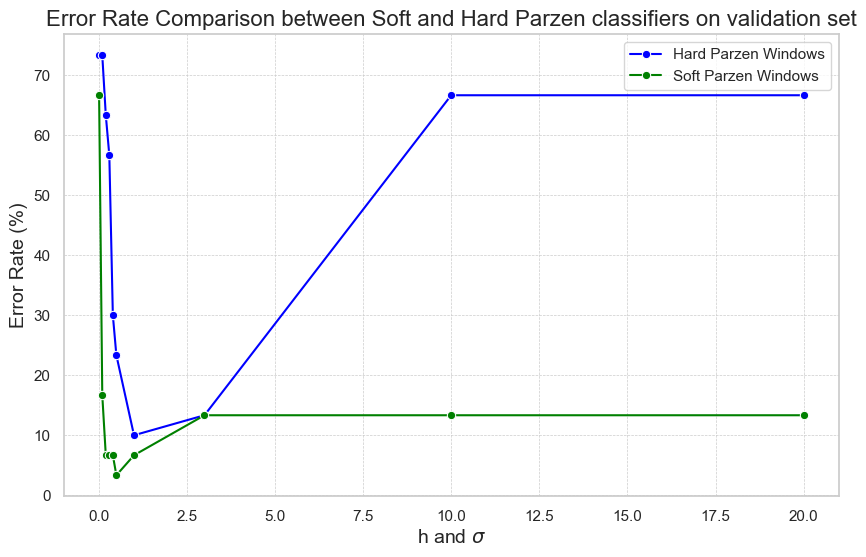

[[0.73333333 0.73333333 0.63333333 0.56666667 0.3        0.23333333
  0.1        0.13333333 0.66666667 0.66666667]
 [0.66666667 0.16666667 0.06666667 0.06666667 0.06666667 0.03333333
  0.06666667 0.13333333 0.13333333 0.13333333]]


In [9]:
dataset = split_dataset(iris)

X_train = dataset[0][:,0:4]
y_train = dataset[0][:,4]

X_valid = dataset[1][:,0:4]
y_valid = dataset[1][:,4]

X_test = dataset[2][:,0:4]
y_test = dataset[2][:, 4]

errorRate = ErrorRate(X_train, y_train, X_valid, y_valid)

listOfValues = np.array([0.01, 0.1, 0.2, 0.3, 0.4, 0.5, 1.0, 3.0, 10.0, 20.0])

# Set Seaborn style for a prettier plot
sns.set(style="whitegrid")

# Create the plot
plt.figure(figsize=(10, 6))

# Plot y1
sns.lineplot(x=listOfValues, y=errorRate.get_val_errors()[0,:]*100, label='Hard Parzen Windows', marker='o', color='blue')

# Plot y2
sns.lineplot(x=listOfValues, y=errorRate.get_val_errors()[1,:]*100, label='Soft Parzen Windows', marker='o', color='green')

# Add titles and labels
plt.title('Error Rate Comparison between Soft and Hard Parzen classifiers on validation set', fontsize=16)
plt.xlabel('h and $\sigma$', fontsize=14)
plt.ylabel('Error Rate (%)', fontsize=14)

# Add a grid
plt.grid(True, which='both', linestyle='--', linewidth=0.5)

# Show the legend
plt.legend()

# Show the plot
plt.show()

print(errorRate.get_val_errors())


In [10]:
dataset = split_dataset(iris)

X_train = dataset[0][:,0:4]
y_train = dataset[0][:,4]

X_valid = dataset[1][:,0:4]
y_valid = dataset[1][:,4]

X_test = dataset[2][:,0:4]
y_test = dataset[2][:, 4]

listOfValues = np.array([0.01, 0.1, 0.2, 0.3, 0.4, 0.5, 1.0, 3.0, 10.0, 20.0])

n_Train = X_train.shape[0]
n_Valid = X_valid.shape[0]

projections_Train = np.zeros((500, n_Train, 2))
projections_Valid = np.zeros((500, n_Valid, 2))

for i in range(500):
    A = np.random.normal(0, 1, (4, 2))
    
    projections_Train[i] = random_projections(X_train, A)  # Project the entire dataset
    projections_Valid[i] = random_projections(X_valid, A)

hard_errors = np.zeros((500, 10))
soft_errors = np.zeros((500, 10))

for i in range(500):
    errorRate = ErrorRate(projections_Train[i,:,:], y_train, projections_Valid[i,:,:], y_valid)
    errors = errorRate.get_val_errors()
    hard_errors[i] = errors[0]
    soft_errors[i] = errors[1]


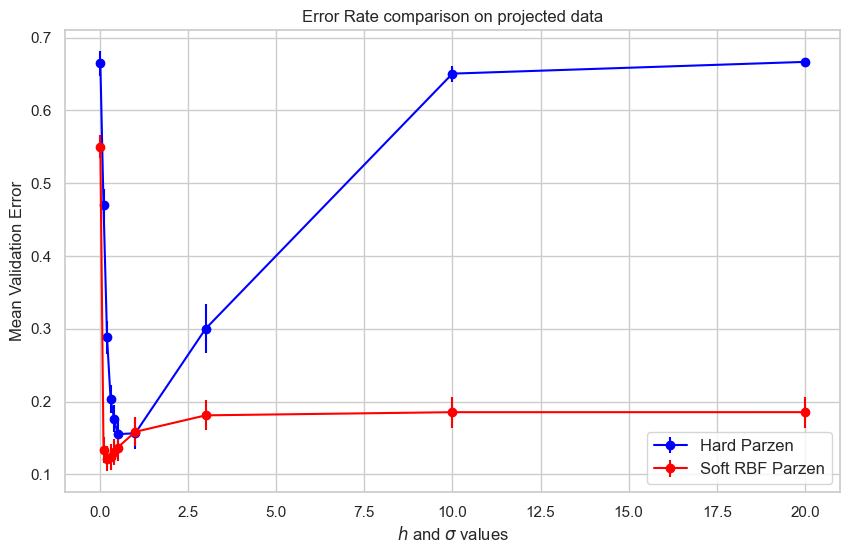

[0.66453333 0.46933333 0.288      0.2036     0.1762     0.15513333
 0.1564     0.3002     0.65053333 0.66666667]
[0.55033333 0.13333333 0.12146667 0.1236     0.13066667 0.13673333
 0.15833333 0.181      0.18533333 0.1854    ]


In [11]:
mean_hard_errors = np.mean(hard_errors, axis = 0)
mean_soft_errors = np.mean(soft_errors, axis = 0)

std_hard_errors = np.std(hard_errors, axis = 0, ddof = 1)
std_soft_errors = np.std(soft_errors, axis = 0, ddof = 1)

error_bars_hard = 0.2 * std_hard_errors
error_bars_soft = 0.2 * std_soft_errors

sns.set(style = "whitegrid")

plt.figure(figsize=(10,6))

plt.errorbar(listOfValues, mean_hard_errors, yerr=error_bars_hard, fmt='o-', label='Hard Parzen', color='blue')
plt.errorbar(listOfValues, mean_soft_errors, yerr=error_bars_soft, fmt='o-', label='Soft RBF Parzen', color='red')

# Labels and title
plt.xlabel('$h$ and $\sigma$ values')
plt.ylabel('Mean Validation Error')
plt.title('Error Rate comparison on projected data')
plt.legend(fontsize = 12)
plt.grid(True)
plt.show()

print(mean_hard_errors)
print(mean_soft_errors)

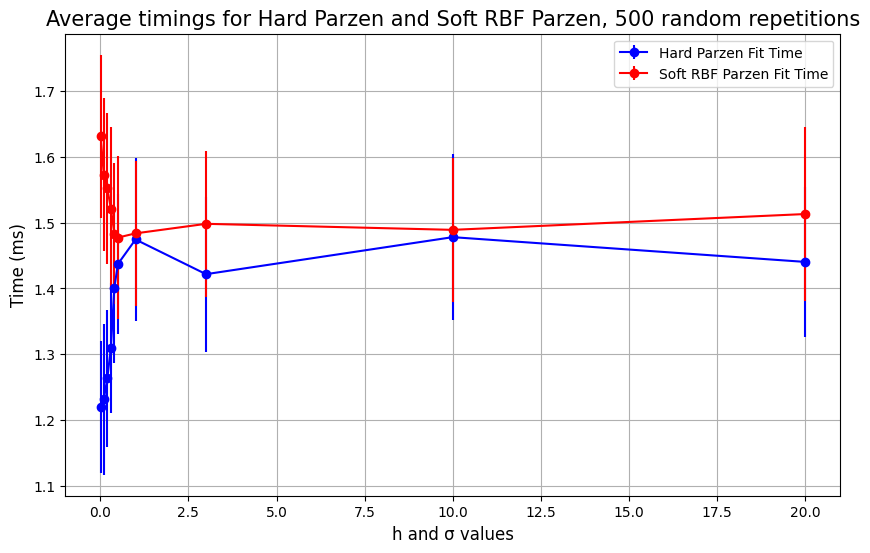

In [32]:
dataset = split_dataset(iris)

X_train = dataset[0][:,0:4]
y_train = dataset[0][:,4]

X_valid = dataset[1][:,0:4]
y_valid = dataset[1][:,4]

X_test = dataset[2][:,0:4]
y_test = dataset[2][:, 4]

# Example of testing time for different values of h for Hard Parzen
listOfValues = [0.01, 0.1, 0.2, 0.3, 0.4, 0.5, 1.0, 3.0, 10.0, 20.0]
'''                              

# Initialize lists to store timings
fit_times_hard = []
predict_times_hard = []
fit_times_soft = []
predict_times_soft = []

for h in listOfValues:
    # Initialize the Hard Parzen classifier
    f = HardParzen(h)
    
    # Measure the time to fit the model
    start_time = time.perf_counter()
    f.fit(X_train, y_train)
    end_time = time.perf_counter()

    fit_times_hard.append((end_time - start_time) * 1_000)
        
    # Measure the time to make predictions
    start_time = time.perf_counter()
    predictions = f.predict(X_valid)
    end_time = time.perf_counter()

    predict_times_hard.append((end_time - start_time) * 1_000)

for sigma in listOfValues:
    # Initialize the Soft RBF Parzen classifier
    f = SoftRBFParzen(sigma)
    
    # Measure the time to fit the model
    start_time = time.perf_counter()
    f.fit(X_train, y_train)
    end_time = time.perf_counter()
    
    fit_times_soft.append((end_time - start_time) * 1_000)
    
    # Measure the time to make predictions
    start_time = time.perf_counter()
    predictions = f.predict(X_valid)
    end_time = time.perf_counter()
    
    predict_times_soft.append((end_time - start_time) * 1_000)
'''

hard_Parzen_time = []
soft_Parzen_time = []

for i in range(1000):
    errors = ErrorRate(X_train, y_train, X_valid, y_valid)
    get_times = errors.get_times(listOfValues)
    hard_Parzen_time.append(get_times[0])
    soft_Parzen_time.append(get_times[1])

hard_Parzen_time_np = np.array(hard_Parzen_time)
soft_Parzen_time_np = np.array(soft_Parzen_time)

std_hard_time = np.std(hard_Parzen_time_np, axis = 0, ddof = 1)
std_soft_time = np.std(soft_Parzen_time_np, axis = 0, ddof = 1)

error_bars_hard_time = 0.2 * std_hard_time
error_bars_soft_time = 0.2 * std_soft_time

mean_hard_Parzen_time = np.mean(hard_Parzen_time_np, axis = 0)
mean_soft_Parzen_time = np.mean(soft_Parzen_time_np, axis = 0)

# Plotting the results
plt.figure(figsize=(10, 6))

# Plot for Hard Parzen
plt.errorbar(listOfValues, mean_hard_Parzen_time, yerr=error_bars_hard_time, fmt='o-', label='Hard Parzen Fit Time', color='blue')
#plt.plot(listOfValues, predict_times_hard, 's-', label='Hard Parzen Predict Time', color='cyan')

# Plot for Soft RBF Parzen
plt.errorbar(listOfValues, mean_soft_Parzen_time, yerr=error_bars_soft_time, fmt='o-', label='Soft RBF Parzen Fit Time', color='red')
#plt.plot(listOfValues, predict_times_soft, 's-', label='Soft RBF Parzen Predict Time', color='orange')

# Customizing the plot
plt.xlabel('h and σ values', fontsize=12)
plt.ylabel('Time (ms)', fontsize=12)
plt.title('Average timings for Hard Parzen and Soft RBF Parzen, 500 random repetitions', fontsize=15)
plt.legend()
plt.grid(True)

# Show the plot
plt.show()